## Enabling Import of Custom Python Modules from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S10')

In [0]:
from torch.utils.data import DataLoader, Dataset

In [3]:
from albumentations import *
from albumentations.pytorch import ToTensor
import data_preprocess_Albumentation_module_1
import resnet
import train_test_module_CrossEntropy
import gradcam_module
import lr_finder_module
import misclassified_module

CUDA Available? True


In [0]:
from __future__ import print_function
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

### Using GPU instead of CPU

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [6]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_preprocess_Albumentation_module_1.albumentation_train())

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_preprocess_Albumentation_module_1.albumentation_test())

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



In [0]:
trainloader, testloader = data_preprocess_Albumentation_module_1.get_train_test_loader(trainset, testset)

plane   dog  deer  deer


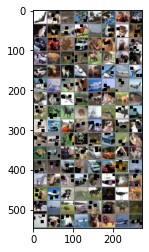

In [8]:
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
images.shape

torch.Size([128, 3, 32, 32])

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [10]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = resnet.ResNet18().to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [11]:
def test():
    net = resnet.ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())
test()

torch.Size([1, 10])


## LR Finder


Learning rate search finished. See the graph with {finder_name}.plot()


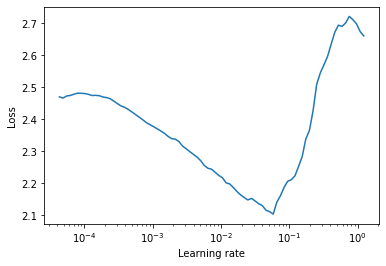

In [12]:
from torch.optim.lr_scheduler import StepLR

net =  resnet.ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0005)
lr_finder = lr_finder_module.LRFinder(net, optimizer, criterion)
lr_finder.range_test(trainloader, start_lr=1e-5, end_lr=2, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state


In [13]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss, best_lr))

Best Loss: 2.102624890105638
Best Learning Rate: 0.0580405202916009


In [18]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

net =  resnet.ResNet18().to(device)
optimizer = optim.SGD(net.parameters(), lr=best_lr, momentum=0.9, weight_decay=0.0005)
#scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-5, factor=0.1, patience = 2)

EPOCHS = 35
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_test_module_CrossEntropy.train(net, device, trainloader, optimizer, epoch)
    train_test_module_CrossEntropy.test(net, device, testloader)
    scheduler.step(train_test_module_CrossEntropy.test_losses[-1])

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.3426722288131714 Batch_id=390 Accuracy=39.22: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -2.7158, Accuracy: 5402/10000 (54.02%)

EPOCH: 1


Loss=1.0254786014556885 Batch_id=390 Accuracy=57.00: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.1162, Accuracy: 6598/10000 (65.98%)

EPOCH: 2


Loss=0.7718777656555176 Batch_id=390 Accuracy=67.50: 100%|██████████| 391/391 [03:27<00:00,  1.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.2495, Accuracy: 7053/10000 (70.53%)

EPOCH: 3


Loss=0.7866119146347046 Batch_id=390 Accuracy=73.78: 100%|██████████| 391/391 [03:22<00:00,  1.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.8487, Accuracy: 7461/10000 (74.61%)

EPOCH: 4


Loss=0.5197596549987793 Batch_id=390 Accuracy=77.85: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.2608, Accuracy: 7538/10000 (75.38%)

EPOCH: 5


Loss=0.5934593677520752 Batch_id=390 Accuracy=80.04: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.1550, Accuracy: 7968/10000 (79.68%)

EPOCH: 6


Loss=0.44267839193344116 Batch_id=390 Accuracy=82.31: 100%|██████████| 391/391 [03:28<00:00,  1.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.9459, Accuracy: 7980/10000 (79.80%)

EPOCH: 7


Loss=0.45933276414871216 Batch_id=390 Accuracy=83.37: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.2597, Accuracy: 7935/10000 (79.35%)

EPOCH: 8


Loss=0.3701063096523285 Batch_id=390 Accuracy=84.86: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.4621, Accuracy: 8260/10000 (82.60%)

EPOCH: 9


Loss=0.5358847379684448 Batch_id=390 Accuracy=85.96: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.1213, Accuracy: 8169/10000 (81.69%)

EPOCH: 10


Loss=0.4852136969566345 Batch_id=390 Accuracy=86.86: 100%|██████████| 391/391 [03:28<00:00,  1.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.7186, Accuracy: 8418/10000 (84.18%)

EPOCH: 11


Loss=0.39712291955947876 Batch_id=390 Accuracy=87.26: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.4270, Accuracy: 8545/10000 (85.45%)

EPOCH: 12


Loss=0.28544101119041443 Batch_id=390 Accuracy=88.18: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8045, Accuracy: 8532/10000 (85.32%)

EPOCH: 13


Loss=0.41492414474487305 Batch_id=390 Accuracy=88.53: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.3115, Accuracy: 8395/10000 (83.95%)

EPOCH: 14


Loss=0.3213837444782257 Batch_id=390 Accuracy=88.87: 100%|██████████| 391/391 [03:28<00:00,  1.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.4107, Accuracy: 8470/10000 (84.70%)

EPOCH: 15


Loss=0.44580477476119995 Batch_id=390 Accuracy=89.01: 100%|██████████| 391/391 [03:22<00:00,  1.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.0806, Accuracy: 8523/10000 (85.23%)

EPOCH: 16


Loss=0.3988482654094696 Batch_id=390 Accuracy=89.56: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.7846, Accuracy: 8321/10000 (83.21%)

EPOCH: 17


Loss=0.4767685532569885 Batch_id=390 Accuracy=89.62: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.1939, Accuracy: 8645/10000 (86.45%)

EPOCH: 18


Loss=0.387338787317276 Batch_id=390 Accuracy=89.86: 100%|██████████| 391/391 [03:28<00:00,  1.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.6408, Accuracy: 8091/10000 (80.91%)

EPOCH: 19


Loss=0.29254618287086487 Batch_id=390 Accuracy=90.06: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.9321, Accuracy: 8369/10000 (83.69%)

EPOCH: 20


Loss=0.2648899555206299 Batch_id=390 Accuracy=90.33: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.6555, Accuracy: 8274/10000 (82.74%)

EPOCH: 21


Loss=0.1547628790140152 Batch_id=390 Accuracy=95.16: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.8190, Accuracy: 9025/10000 (90.25%)

EPOCH: 22


Loss=0.08753734081983566 Batch_id=390 Accuracy=96.79: 100%|██████████| 391/391 [03:27<00:00,  1.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.1881, Accuracy: 9105/10000 (91.05%)

EPOCH: 23


Loss=0.07329503446817398 Batch_id=390 Accuracy=97.47: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.3775, Accuracy: 9085/10000 (90.85%)

EPOCH: 24


Loss=0.03313429653644562 Batch_id=390 Accuracy=97.91: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.6201, Accuracy: 9113/10000 (91.13%)

EPOCH: 25


Loss=0.09754519909620285 Batch_id=390 Accuracy=98.15: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.7436, Accuracy: 9138/10000 (91.38%)

EPOCH: 26


Loss=0.04296126216650009 Batch_id=390 Accuracy=98.50: 100%|██████████| 391/391 [03:27<00:00,  1.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.8440, Accuracy: 9144/10000 (91.44%)

EPOCH: 27


Loss=0.008973890915513039 Batch_id=390 Accuracy=98.72: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.8977, Accuracy: 9132/10000 (91.32%)

EPOCH: 28


Loss=0.03454575687646866 Batch_id=390 Accuracy=98.86: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.9800, Accuracy: 9119/10000 (91.19%)

EPOCH: 29


Loss=0.03633971884846687 Batch_id=390 Accuracy=98.90: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.9234, Accuracy: 9142/10000 (91.42%)

EPOCH: 30


Loss=0.040001221001148224 Batch_id=390 Accuracy=98.93: 100%|██████████| 391/391 [03:27<00:00,  1.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.9732, Accuracy: 9138/10000 (91.38%)

EPOCH: 31


Loss=0.044761404395103455 Batch_id=390 Accuracy=98.98: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.8770, Accuracy: 9130/10000 (91.30%)

EPOCH: 32


Loss=0.024438226595520973 Batch_id=390 Accuracy=99.19: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.9284, Accuracy: 9131/10000 (91.31%)

EPOCH: 33


Loss=0.010247278027236462 Batch_id=390 Accuracy=99.27: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.8968, Accuracy: 9141/10000 (91.41%)

EPOCH: 34


Loss=0.01288710255175829 Batch_id=390 Accuracy=99.27: 100%|██████████| 391/391 [03:28<00:00,  1.88it/s]



Test set: Average loss: -9.9802, Accuracy: 9157/10000 (91.57%)



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [0]:
# Averaging the training accuracies across all batches to produce one value per epoch
n=391
train_acc = ([sum(train_test_module_CrossEntropy.train_acc[i:i+n])//n for i in range(0,len(train_test_module_CrossEntropy.train_acc),n)])

In [32]:
len(train_acc), len(train_test_module_CrossEntropy.test_acc) 

(38, 38)

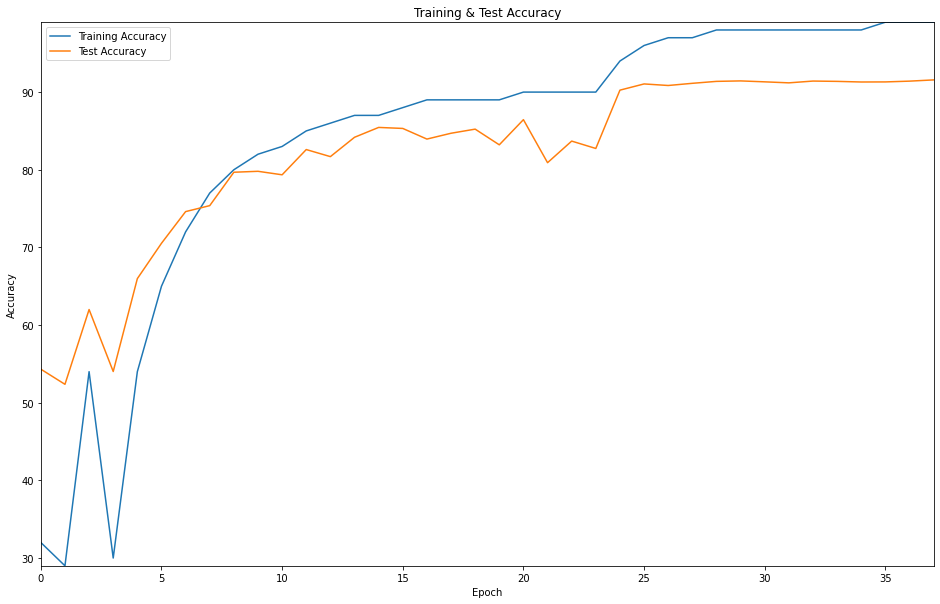

In [34]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(train_acc,label='Training Accuracy')
ax.plot(train_test_module_CrossEntropy.test_acc,label='Test Accuracy')
plt.autoscale(enable = True, axis = 'both',tight = 'true')
plt.title("Training & Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

from google.colab import files
plt.savefig("Training & Test Accuracy.png")
files.download("Training & Test Accuracy.png")

GroundTruth:    cat  ship  ship plane


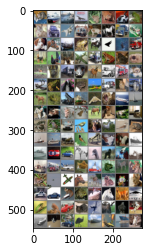

In [19]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = net(images.cuda())

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [21]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data, target in testloader:
        images, labels = data.to(device), target.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 91 %


In [35]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data, target in testloader:
        images, labels = data.to(device), target.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 89 %
Accuracy of   car : 100 %
Accuracy of  bird : 84 %
Accuracy of   cat : 85 %
Accuracy of  deer : 96 %
Accuracy of   dog : 84 %
Accuracy of  frog : 86 %
Accuracy of horse : 92 %
Accuracy of  ship : 96 %
Accuracy of truck : 92 %


## Misclasified Images & GradCam 

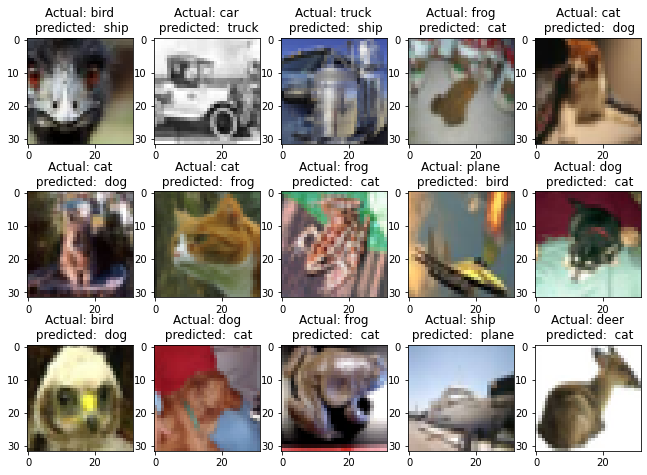

<Figure size 432x288 with 0 Axes>

In [69]:
images, actuals, preds = misclassified_module.test_misclassified(net,device,testloader)
misclassified_module.plot_images(images, actuals, preds, classes)
from google.colab import files
plt.savefig("Misclassified Images.png")
files.download("Misclassified Images.png")

In [0]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = gradcam_module.VisualizeCam(net,classes, target_layers)

In [0]:
temp = [i.item() for i in actuals]
images_x = torch.Tensor(images) # transform to torch tensor
actuals_y = torch.Tensor(temp)
misclasified_dataset = TensorDataset(images_x,actuals_y) # create your datset
misclasified_dataloader = DataLoader(misclasified_dataset)

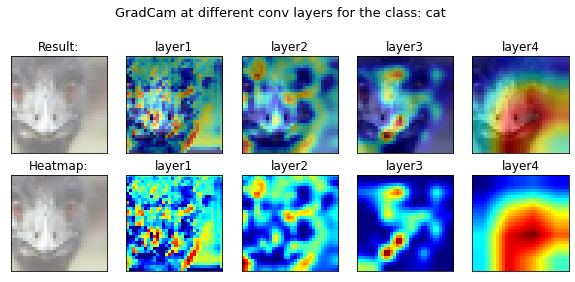

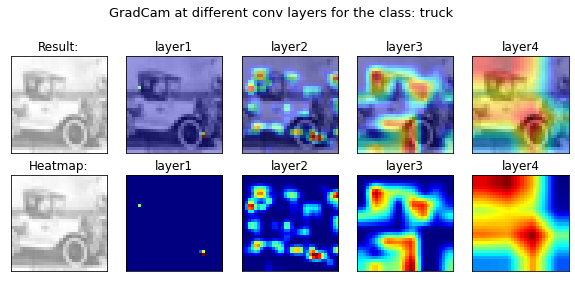

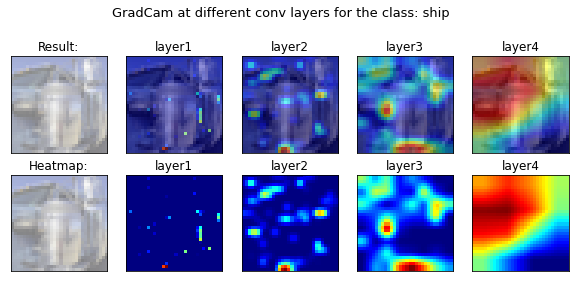

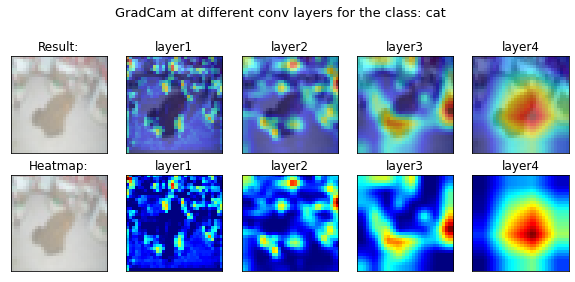

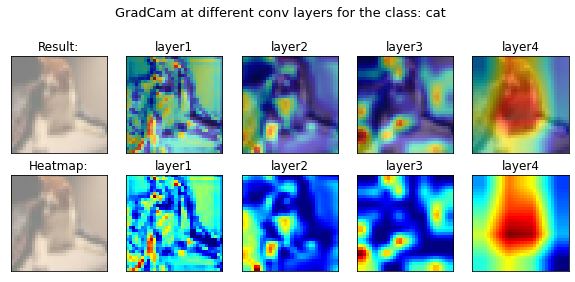

In [70]:
dataiter = iter(misclasified_dataloader)
for i in range(5):
  img, label = dataiter.next()
  viz_cam(img, target_layers)

